# ECDA Preschool Demand Forecasting Analysis

## Executive Summary

This analysis forecasts subzone-level demand for preschool services in Singapore over the next 5 years (2026-2030) to help the Early Childhood Development Agency (ECDA) prioritize where to build or relocate preschools.

### Key Findings:
- **Total projected preschoolers**: ~96,000-99,000 annually across Singapore
- **Top shortage areas (2030)**: Brickworks (-21 centres), Tampines North (-19 centres), Yishun East (-14 centres)
- **Peak demand subzones**: Tampines East, Yishun East, Woodlands East, Fernvale

### Methodology Overview:
1. **Historical fertility analysis**: Applied age-specific fertility rates to population demographics
2. **BTO impact modeling**: Estimated births from new BTO residents using completion timelines
3. **Subzone-level aggregation**: Combined existing residents and new BTO families by subzone
4. **Capacity gap analysis**: Compared projected demand against existing childcare centre capacity (100 children/centre)

### Key Assumptions:
- Preschool age range: 18 months to 6 years
- Each childcare centre accommodates up to 100 children
- Children attend preschools within their subzone of residence
- Ethnic homogeneity in subzones (uniform fertility rates)
- One childbearing woman per BTO household (ages 25-39)
- Births from resale flats and private property are excluded because they are not covered by the available data

## 1. Setup and Data Import

### Required Libraries
- **Data processing**: pandas, geopandas for demographic and geospatial analysis
- **Visualization**: matplotlib, ipywidgets for interactive charts and maps
- **Geolocation**: requests for postal code to lat/lng conversion via OneMap API


In [2]:
import os
import html
import re
import requests
from datetime import datetime
from pathlib import Path

import geopandas as gpd
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
import pandas as pd 
from shapely.geometry import Point

### Data Sources and File Paths

The analysis relies on multiple government datasets:

- **`respopagesex2000to2020e.xlsx`**: Resident population by age and sex
- **`BirthsAndFertilityRatesAnnual.csv`**: Historical fertility rates by maternal age
- **`ListingofCentres.csv`**: Current childcare centre locations and details
- **`btomapping.csv`**: BTO project completion timelines and unit counts
- **`Master Plan 2019 Subzone Boundary (No Sea) (GEOJSON).geojson`**: Subzone geographic boundaries
- **`preschools_data_processed.csv`**: Processed childcare centre data with lat/lon coordinates


In [3]:
DATA_DIR = Path(os.getcwd()).parent / "data"
EXISTING_RESIDENTS_PATH = Path(DATA_DIR) / "respopagesex2000to2020e.xlsx"
FERTILITY_DATA_PATH = Path(DATA_DIR) / "BirthsAndFertilityRatesAnnual.csv"
CHILDCARE_CENTRES_DATA_PATH = Path(DATA_DIR) / "ListingofCentres.csv"
BTO_DATA_PATH = Path(DATA_DIR) / "btomapping.csv"
SUBZONES_DATA_PATH = Path(DATA_DIR) / "Master Plan 2019 Subzone Boundary (No Sea) (GEOJSON).geojson"

PROCESSED_CHILDCARE_CENTRES_DATA_PATH = DATA_DIR / "preschools_data_processed.csv"

## 2. Modeling Assumptions and Constraints

The following assumptions underpin our forecasting model. These represent necessary simplifications given data availability and computational constraints:

### Population Dynamics
- **Ethnic homogeneity**: Due to Singapore's ethnic integration policy, we assume uniform fertility rates across subzones
- **BTO family composition**: One childbearing woman per household, with women aged 25-39 (peak fertility years)
- **Birth timing**: Couples start having children only after moving into BTOs

### Geographic and Service Constraints  
- **Catchment areas**: Children attend preschools within their subzone of residence (no cross-boundary enrollment)
- **Service capacity**: Each childcare centre accommodates up to 100 children (ECDA planning norm)
- **Terminology**: "Childcare centre" and "preschool" are used interchangeably

### Scope Limitations
- **Housing focus**: Analysis covers only BTO residents for new demand (excludes resale flats, private property)
- **Age distribution**: Even distribution assumed among women aged 25-39 in BTO households


## 3. Demographic Calculations and Projections

### 3.1 Preschooler Age Range and Birth Year Mapping

We define preschoolers as children aged 18 months to 6 years (72 months). To forecast demand for years 2026-2030, we need to identify which birth cohorts will be of preschool age during each forecast year.


In [4]:
# We are estimating preschool demand for the next 5 years (2026-2030)
# The first child to start preschool in 2026 would have been half the cohort born in 2024
min_preschool_age, max_preschool_age = 18, 6 * 12
current_year = datetime.now().year


def birth_years_for_single_forecast_year(
    forecast_year,
    min_preschool_age=min_preschool_age,
    max_preschool_age=max_preschool_age,
):
    start_birth_year = forecast_year - round(max_preschool_age / 12)
    end_birth_year = forecast_year - round(min_preschool_age / 12)
    return list(range(start_birth_year, end_birth_year + 1))

current_year = datetime.now().year
forecast_years = list(range(current_year + 1, current_year + 6))
print(f"Forecast years: {forecast_years}")


def birth_years_for_multiple_forecast_years(forecast_years):
    birth_years_all = None
    for forecast_year in forecast_years:
        if birth_years_all is None:
            birth_years_all = birth_years_for_single_forecast_year(
                forecast_year, min_preschool_age=18, max_preschool_age=6 * 12
            )
        else:
            birth_years_all.append(
                max(
                    birth_years_for_single_forecast_year(
                        forecast_year, min_preschool_age=18, max_preschool_age=6 * 12
                    )
                )
            )
    return birth_years_all


birth_years_all = birth_years_for_multiple_forecast_years(forecast_years)
print(f"All birth years of preschoolers in the next 5 years: {birth_years_all}")

Forecast years: [2026, 2027, 2028, 2029, 2030]
All birth years of preschoolers in the next 5 years: [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028]


### 3.2 Fertility Rate Analysis and Extrapolation

Historical fertility data provides age-specific birth rates per 1000 women. We need to extrapolate these rates for future years (2025-2028) since the dataset ends in 2024.

Considering the available time for this assignment, the extrapolation approach used here was a simple filling in of missing years witht he latest available birth rates (2024). Given more time, a more sophisticated approach will be to use a time series model (e.g., Prophet) for extrapolation, but this is itself requires careful tuning and validation.


In [5]:
fertility_data = pd.read_csv(FERTILITY_DATA_PATH, index_col=0)
fertility_data

,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,...,1969,1968,1967,1966,1965,1964,1963,1962,1961,1960
DataSeries,,,,,,,,,,,,,,,,,,,,,
Total Fertility Rate (TFR),0.97,0.97,1.04,1.12,1.10,1.14,1.14,1.16,1.20,1.24,...,3.22,3.53,3.91,4.46,4.66,4.97,5.16,5.21,5.41,5.76
15 - 19 Years,2.30,2.20,2.10,2.20,2.30,2.50,2.50,2.60,2.70,2.70,...,27.1,30.9,35.8,33,35.9,38.3,45.7,52,63.4,69.6
20 - 24 Years,9.80,10.60,11.20,11.70,12.70,12.70,14.40,15.10,17.00,18.70,...,150.1,165.8,195.8,218.5,227.1,240,249,245.5,241.1,250.5
25 - 29 Years,42.60,43.70,48.80,53.40,54.60,59.40,60.60,62.20,65.80,68.70,...,227.8,236.6,244.7,261.2,259.5,277.6,287.2,291.7,304.9,323.9
30 - 34 Years,79.30,78.70,86.70,92.90,90.80,92.40,92.90,93.30,96.20,98.50,...,134.3,152,166.7,202,216.2,226.7,228.7,231.5,238.4,259.7
35 - 39 Years,50.00,47.90,49.40,53.60,49.00,50.10,48.40,48.60,49.70,49.90,...,75.2,85.2,95.9,124.8,138.1,147.7,156.1,156.2,168.9,176.7
40 - 44 Years,10.20,9.60,9.80,10.20,9.50,9.90,8.80,9.00,8.80,8.90,...,29.4,35.3,42.9,51.7,54.9,62.8,64.9,65.1,64.8,70.7
45 - 49 Years,0.70,0.60,0.40,0.30,0.50,0.40,0.50,0.50,0.30,0.40,...,na,na,na,na,na,na,na,na,na,na
Chinese,0.83,0.81,0.87,0.96,0.94,0.99,0.98,1.01,1.07,1.10,...,3.05,3.29,3.59,4.08,4.31,4.6,4.83,4.92,5.2,5.62


In [6]:
# Remove leading spaces from indices
fertility_data.index = fertility_data.index.str.strip()
fertility_data.index

Index(['Total Fertility Rate (TFR)', '15 - 19 Years', '20 - 24 Years',
       '25 - 29 Years', '30 - 34 Years', '35 - 39 Years', '40 - 44 Years',
       '45 - 49 Years', 'Chinese', 'Malays', 'Indians',
       'Gross Reproduction Rate', 'Net Reproduction Rate', 'Crude Birth Rate',
       'Total Live-Births', 'Resident Live-Births', 'Citizen Live-Births'],
      dtype='object', name='DataSeries')

In [7]:
# We are missing the number of births for 2025–2031
# Assume that the number of births in 2025–2031 is the same as the number of births in 2024
def extrapolate_births(fertility_data, birth_years_all):
    available_years = fertility_data.columns
    available_years = [int(year) for year in available_years]
    latest_available_year = max(available_years)
    
    if latest_available_year < max(birth_years_all):
        for year in range(latest_available_year+1, max(birth_years_all)+1):
            if year not in available_years:
                fertility_data[str(year)] = fertility_data[str(latest_available_year)]

    return fertility_data

fertility_data = extrapolate_births(fertility_data, birth_years_all)
fertility_data.head()

,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,...,1965,1964,1963,1962,1961,1960,2025,2026,2027,2028
DataSeries,,,,,,,,,,,,,,,,,,,,,
Total Fertility Rate (TFR),0.97,0.97,1.04,1.12,1.1,1.14,1.14,1.16,1.2,1.24,...,4.66,4.97,5.16,5.21,5.41,5.76,0.97,0.97,0.97,0.97
15 - 19 Years,2.30,2.20,2.10,2.20,2.3,2.50,2.50,2.60,2.7,2.70,...,35.9,38.3,45.7,52,63.4,69.6,2.30,2.30,2.30,2.30
20 - 24 Years,9.80,10.60,11.20,11.70,12.7,12.70,14.40,15.10,17.0,18.70,...,227.1,240,249,245.5,241.1,250.5,9.80,9.80,9.80,9.80
25 - 29 Years,42.60,43.70,48.80,53.40,54.6,59.40,60.60,62.20,65.8,68.70,...,259.5,277.6,287.2,291.7,304.9,323.9,42.60,42.60,42.60,42.60
30 - 34 Years,79.30,78.70,86.70,92.90,90.8,92.40,92.90,93.30,96.2,98.50,...,216.2,226.7,228.7,231.5,238.4,259.7,79.30,79.30,79.30,79.30


### 3.3 Current Demographic Profile by Subzone

We analyze the existing population structure to establish baseline demand from current residents. This focuses on women of childbearing age (15-49 years) who will contribute to preschooler demand over the forecast period.

The existing residents data provides the foundation for calculating baseline preschooler demand from current population. We use 2020 data as our most recent complete demographic snapshot.


In [8]:
all_mother_ages = ["15 - 19 Years", "20 - 24 Years", "25 - 29 Years", "30 - 34 Years", "35 - 39 Years", "40 - 44 Years", "45 - 49 Years"]

# Number of births per 1000 women per year
birth_years_str = [str(year) for year in birth_years_all]
all_crude_birth_rates_by_age = fertility_data.loc[all_mother_ages, birth_years_str]
all_crude_birth_rates_by_age

,2020,2021,2022,2023,2024,2025,2026,2027,2028
DataSeries,,,,,,,,,
15 - 19 Years,2.3,2.2,2.1,2.2,2.3,2.3,2.3,2.3,2.3
20 - 24 Years,12.7,11.7,11.2,10.6,9.8,9.8,9.8,9.8,9.8
25 - 29 Years,54.6,53.4,48.8,43.7,42.6,42.6,42.6,42.6,42.6
30 - 34 Years,90.8,92.9,86.7,78.7,79.3,79.3,79.3,79.3,79.3
35 - 39 Years,49.0,53.6,49.4,47.9,50.0,50.0,50.0,50.0,50.0
40 - 44 Years,9.5,10.2,9.8,9.6,10.2,10.2,10.2,10.2,10.2
45 - 49 Years,0.5,0.3,0.4,0.6,0.7,0.7,0.7,0.7,0.7


## Get existing demographics in subzones

**Data Processing Steps:**
1. **Filter for relevant records**: Remove totals and focus on female residents (childbearing population)
2. **Subzone-level analysis**: Exclude territory-wide aggregations to get granular geographic data  
3. **Clean data types**: Ensure numeric counts are properly formatted for calculations

This cleaning process ensures we have reliable demographic data for each subzone's female population by specific age groups.


In [9]:
# Get latest demographics (2020)
existing_residents_data = pd.read_excel(EXISTING_RESIDENTS_PATH, sheet_name="2020", header=2)
existing_residents_data.head(15)

,Planning Area,Subzone,Age,Sex,2020
0,Total,Total,Total,Total,4044210
1,Total,Total,Total,Males,1977560
2,Total,Total,Total,Females,2066650
3,Total,Total,0,Total,33430
4,Total,Total,0,Males,17040
5,Total,Total,0,Females,16390
6,Total,Total,1,Total,35590
7,Total,Total,1,Males,17980
8,Total,Total,1,Females,17610
9,Total,Total,2,Total,36390


In [10]:
def clean_existing_residents_data(existing_residents_data):
    existing_residents_in_subzones = existing_residents_data[existing_residents_data["Subzone"] != "Total"]
    existing_residents_in_subzones = existing_residents_in_subzones[existing_residents_in_subzones["Age"] != "Total"]
    existing_residents_in_subzones = existing_residents_in_subzones[existing_residents_in_subzones["Sex"] != "Total"]
    existing_residents_in_subzones = existing_residents_in_subzones[existing_residents_in_subzones["Sex"] != "Males"]
    existing_residents_in_subzones = existing_residents_in_subzones[["Subzone", "Age", 2020]]
    existing_residents_in_subzones.rename(columns={2020: "Count"}, inplace=True)
    existing_residents_in_subzones["Count"] = pd.to_numeric(existing_residents_in_subzones["Count"], errors='coerce')
    return existing_residents_in_subzones

existing_residents_in_subzones = clean_existing_residents_data(existing_residents_data)
existing_residents_in_subzones.head()

,Subzone,Age,Count
557,Ang Mo Kio Town Centre,0,10.0
560,Ang Mo Kio Town Centre,1,10.0
563,Ang Mo Kio Town Centre,2,20.0
566,Ang Mo Kio Town Centre,3,10.0
569,Ang Mo Kio Town Centre,4,20.0


**Age Bin Methodology:**

To apply fertility rates accurately, we aggregate individual ages into standard demographic age bins (e.g., "25-29 Years"). This process:

1. **Maps individual ages to bins**: Each age from 15-49 is assigned to its corresponding 5-year age group
2. **Aggregates subzone populations**: Sums women counts within each age bin for each subzone  
3. **Enables fertility rate application**: Allows us to multiply age-specific fertility rates by the appropriate population counts

This aggregation is crucial because fertility data is provided in age group format, not individual ages.


In [11]:
def get_age_bins(mother_ages):
    age_bins = {
        str(age): bin_name
        for bin_name in mother_ages
        for age in range(
            int(bin_name.split(" - ")[0]), 
            int(bin_name.split(" - ")[1].replace(" Years","")) + 1
        )
    }
    return age_bins

def aggregate_women_by_age_bin(existing_residents_in_subzones, age_bins):
    women_by_age_bin = existing_residents_in_subzones
    women_by_age_bin["Age Bin"] = women_by_age_bin["Age"].astype(str).map(age_bins)
    women_by_age_bin.dropna(inplace=True)
    women_by_age_bin = women_by_age_bin.groupby(["Subzone", "Age Bin"])["Count"].sum()
    women_by_age_bin = pd.DataFrame(women_by_age_bin).reset_index()
    return women_by_age_bin

age_bins = get_age_bins(all_mother_ages)
existing_women_by_age_bin = aggregate_women_by_age_bin(existing_residents_in_subzones, age_bins)
existing_women_by_age_bin

,Subzone,Age Bin,Count
0,Admiralty,15 - 19 Years,440.0
1,Admiralty,20 - 24 Years,390.0
2,Admiralty,25 - 29 Years,410.0
3,Admiralty,30 - 34 Years,540.0
4,Admiralty,35 - 39 Years,630.0
...,...,...,...
1503,Yunnan,25 - 29 Years,2850.0
1504,Yunnan,30 - 34 Years,2110.0
1505,Yunnan,35 - 39 Years,2250.0
1506,Yunnan,40 - 44 Years,2430.0


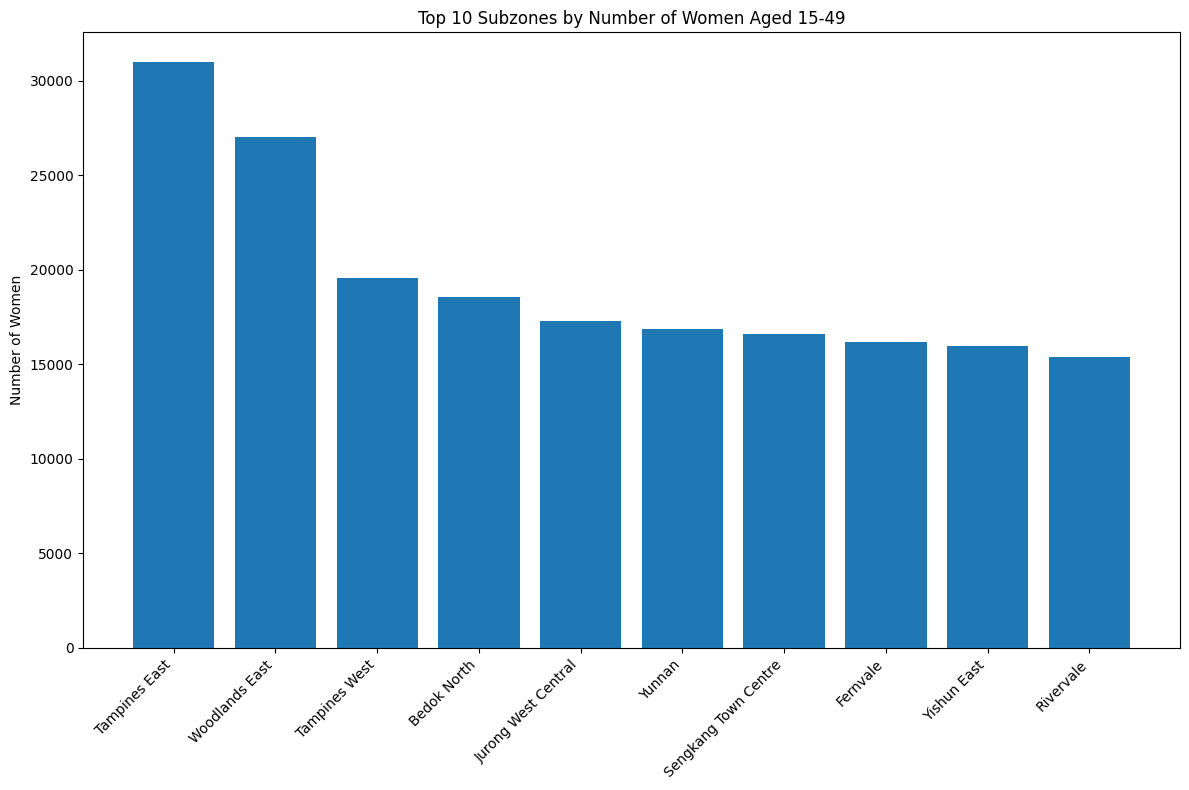

In [12]:
# Plot top 10 subzones by number of women of childbearing age
top_10_subzones = existing_women_by_age_bin.groupby('Subzone')['Count'].sum().nlargest(10)

plt.figure(figsize=(12, 8))
plt.bar(top_10_subzones.index, top_10_subzones.values)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Subzones by Number of Women Aged 15-49')
plt.ylabel('Number of Women')
plt.tight_layout()

## Get number of BTOs in each birth year

### 3.4 BTO Development Impact Analysis

Build-To-Order (BTO) projects represent significant sources of new preschooler demand. We analyze BTO completion timelines and unit counts to estimate when new families will move in and start having children.

We get the birth rates of female BTO residents based on assumptions about likely age ranges of BTO residents.


In [13]:
# Likely ages of mothers in BTOs--peak fertility ages
bto_mother_ages =  ["20 - 24 Years", "25 - 29 Years", "30 - 34 Years", "35 - 39 Years"]

# Number of births per 1000 women per year
bto_crude_birth_rates_by_age = fertility_data.loc[bto_mother_ages, birth_years_str]
bto_crude_birth_rates_by_age

,2020,2021,2022,2023,2024,2025,2026,2027,2028
DataSeries,,,,,,,,,
20 - 24 Years,12.7,11.7,11.2,10.6,9.8,9.8,9.8,9.8,9.8
25 - 29 Years,54.6,53.4,48.8,43.7,42.6,42.6,42.6,42.6,42.6
30 - 34 Years,90.8,92.9,86.7,78.7,79.3,79.3,79.3,79.3,79.3
35 - 39 Years,49.0,53.6,49.4,47.9,50.0,50.0,50.0,50.0,50.0


In [14]:
# Get total births per woman per year, averaged across expected age of women in BTO area
bto_num_children_per_woman_per_year = bto_crude_birth_rates_by_age.mean(axis=0) / 1000
bto_num_children_per_woman_per_year

2020    0.051775
2021    0.052900
2022    0.049025
2023    0.045225
2024    0.045425
2025    0.045425
2026    0.045425
2027    0.045425
2028    0.045425
dtype: float64

In [15]:
bto_data = pd.read_csv(BTO_DATA_PATH)
bto_data.head()

,BTO project name,Region,Planning area,Subzone,Estimated completion year,Total number of units
0,Toa Payoh Apex,Central Region,Toa Payoh,Boon Teck,2018,557
1,Fengshan GreenVille,East Region,Bedok,Bedok North,2018,1058
2,Sun Breeze,North Region,Sembawang,Sembawang Central,2018,700
3,Sun Natura,North Region,Sembawang,Sembawang Central,2018,848
4,Marsiling Greenview,North Region,Woodlands,Woodlands West,2018,1304


In [16]:
bto_data["Estimated completion year"].describe()

count     223.000000
mean     2023.278027
std         3.313066
min      2018.000000
25%      2020.000000
50%      2023.000000
75%      2026.000000
max      2029.000000
Name: Estimated completion year, dtype: float64

In [17]:
# Compute cumulative number of completed BTOs per subzone up to each year
# Pivot table to get subzones as index and completion years as columns, then take cumsum
def get_cumulative_bto_units_by_subzone(bto_data, birth_years):
    bto_data_for_forecast = bto_data[bto_data["Estimated completion year"] <= max(birth_years)]

    bto_units_by_subzone = pd.pivot_table(
        bto_data_for_forecast,
        values='Total number of units', 
        index='Subzone',
        columns='Estimated completion year',
        aggfunc='sum',
        fill_value=0
    ).cumsum(axis=1)

    bto_units_by_subzone.columns = bto_units_by_subzone.columns.astype(str)
    bto_units_by_subzone = bto_units_by_subzone.transpose()

    # Remove whitespace from column names
    bto_units_by_subzone.columns = bto_units_by_subzone.columns.str.strip()

    return bto_units_by_subzone

bto_units_by_subzone = get_cumulative_bto_units_by_subzone(bto_data, birth_years_all)
bto_units_by_subzone.head()

Subzone,Balestier,Plantation,Alexandra North,Aljunied,Anchorvale,Ang Mo Kio Town Centre,Bedok North,Bedok South,Bendemeer,Bidadari,...,Woodlands East,Woodlands Regional Centre,Woodlands South,Woodlands West,Yew Tee,Yio Chu Kang West,Yishun Central,Yishun East,Yuhua East,Yunnan
Estimated completion year,,,,,,,,,,,,,,,,,,,,,
2018,0,0,0,0,511,0,1058,0,0,0,...,0,0,0,1304,0,0,0,1119,0,0
2019,0,0,0,0,511,0,1058,0,738,0,...,0,0,0,1304,0,0,0,1119,0,0
2020,0,0,0,319,1432,0,1630,0,738,0,...,172,0,0,1304,0,0,0,2399,0,0
2021,0,0,0,1273,1432,0,2130,940,738,1018,...,801,0,0,1304,0,0,0,4694,0,0
2022,0,0,0,1273,1639,0,2130,940,738,2373,...,801,0,0,2550,0,0,0,6387,0,599


In [18]:
bto_units_by_subzone.sum(axis=1)

Estimated completion year
2018     15483
2019     28242
2020     42954
2021     61071
2022     81752
2023     96552
2024    106058
2025    121419
2026    138914
2027    157940
2028    174534
dtype: int64

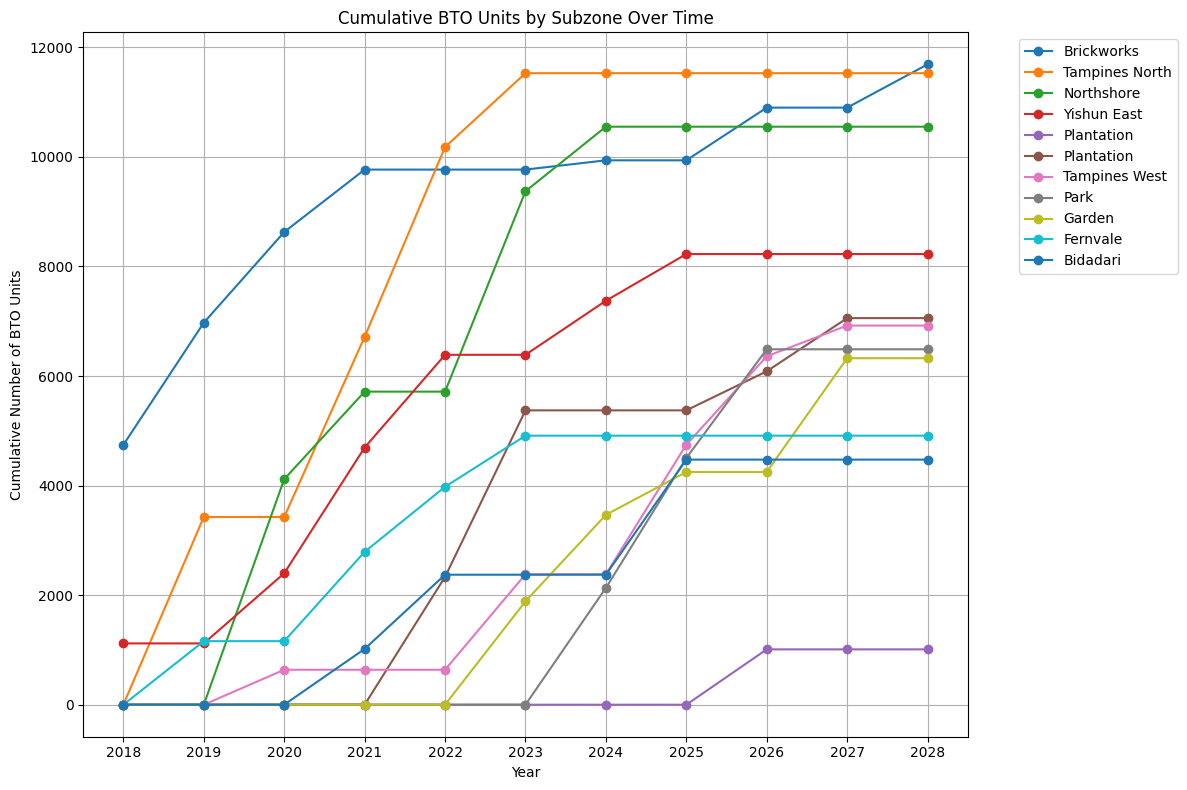

In [19]:
# Plot cumulative BTO units over time for each subzone
plt.figure(figsize=(12, 8))

# Get top 10 subzones by final cumulative total
final_totals = bto_units_by_subzone.iloc[-1].sort_values(ascending=False)
top_10_subzones = final_totals.head(10).index

# Plot line for each top subzone
for subzone in top_10_subzones:
    plt.plot(bto_units_by_subzone.index, 
             bto_units_by_subzone[subzone],
             marker='o',
             label=subzone)

plt.title('Cumulative BTO Units by Subzone Over Time')
plt.xlabel('Year') 
plt.ylabel('Cumulative Number of BTO Units')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Preschooler Demand Forecasting

### 4.1 Core Calculation Methodology

Our forecast combines two sources of preschooler demand:

1. **Existing residents**: Children born to women already living in subzones (using 2020 demographic data)
2. **BTO residents**: Children born to new families moving into completed BTO units

For each forecast year, we calculate:
- Which birth cohorts will be of preschool age
- How many children each group of mothers will have had
- Where these families live (subzone-level aggregation)


In [20]:
def existing_preschoolers_for_year(target_year, births_per_woman_per_year, existing_women_by_age_bin, mother_ages):
    """Calculate preschoolers born to existing women in each subzone for a specific forecast year."""
    
    birth_years_for_target = birth_years_for_single_forecast_year(target_year)
    print(f"Birth years contributing to {target_year} preschoolers: {birth_years_for_target}")
    
    # Initialize result series for each subzone
    all_subzones = existing_women_by_age_bin['Subzone'].unique()
    subzone_preschoolers = pd.Series(0.0, index=all_subzones)

    for birth_year in birth_years_for_target:
        birth_year_str = str(birth_year)
        fertility_rates_by_age = births_per_woman_per_year[birth_year_str] / 1000
        
        # For each subzone, calculate births from existing women
        for subzone in all_subzones:
            subzone_data = existing_women_by_age_bin[
                existing_women_by_age_bin['Subzone'] == subzone
            ]
            
            total_births_in_subzone = 0
            
            # Apply age-specific fertility rates to women in each age group
            for age_bin in mother_ages:
                women_in_age_bin = subzone_data[
                    subzone_data['Age Bin'] == age_bin
                ]['Count'].sum()
                
                if women_in_age_bin > 0 and age_bin in fertility_rates_by_age.index:
                    fertility_rate = fertility_rates_by_age[age_bin]
                    births_from_age_group = women_in_age_bin * fertility_rate
                    total_births_in_subzone += births_from_age_group
            
            # For most recent birth year, only count half (born early in year)
            if birth_year == max(birth_years_for_target):
                total_births_in_subzone *= 0.5
            
            subzone_preschoolers[subzone] += total_births_in_subzone
    
    # Clean up results
    subzone_preschoolers = subzone_preschoolers.fillna(0)
    subzone_preschoolers = subzone_preschoolers.astype(int)

    # TODO: allow for mothers ageing through age groups
    # Not a big issue for current forecast window
    
    return subzone_preschoolers

# Test for a single year
preschoolers_to_existing_women = existing_preschoolers_for_year(2026, all_crude_birth_rates_by_age, existing_women_by_age_bin, all_mother_ages)
preschoolers_to_existing_women

Birth years contributing to 2026 preschoolers: [2020, 2021, 2022, 2023, 2024]


Admiralty           496
Alexandra Hill      376
Alexandra North     120
Aljunied           1392
Anak Bukit          688
                   ... 
Yishun South       1606
Yishun West        1710
Yuhua East          795
Yuhua West          598
Yunnan             2227
Length: 226, dtype: int64

In [21]:
def bto_preschoolers_for_year(target_year, births_per_woman_per_year, bto_units_by_subzone):
    """Calculate preschoolers born to mothers living in new BTOs in each subzone
    for a specific forecast year."""
    birth_years_for_target = birth_years_for_single_forecast_year(target_year)
    subzone_preschoolers = pd.Series(0.0, index=bto_units_by_subzone.columns)
    
    print(f"Birth years contributing to {target_year} preschoolers: {birth_years_for_target}")
    
    for birth_year in birth_years_for_target:
        birth_year_str = str(birth_year)
        
        if birth_year_str in bto_units_by_subzone.index:
            # BTO units available when these children were born
            bto_units = bto_units_by_subzone.loc[birth_year_str]
            
            # Children per woman in this birth year
            fertility_rate = births_per_woman_per_year[birth_year_str]
            
            # Children born = BTO units × fertility rate
            children_from_birth_year = bto_units * fertility_rate
            
            # For most recent birth year, only count half (born early in year)
            if birth_year == max(birth_years_for_target):
                children_from_birth_year *= 0.5
                
            subzone_preschoolers += children_from_birth_year
    
    subzone_preschoolers =  subzone_preschoolers.fillna(0)
    subzone_preschoolers = subzone_preschoolers.astype(int)
    return subzone_preschoolers

# Calculate for a single year
preschoolers_to_bto_women = bto_preschoolers_for_year(2026, bto_num_children_per_woman_per_year, bto_units_by_subzone)
preschoolers_to_bto_women

Birth years contributing to 2026 preschoolers: [2020, 2021, 2022, 2023, 2024]


Subzone
Balestier               0
Plantation              0
Alexandra North         0
Aljunied              232
Anchorvale            341
                     ... 
Yio Chu Kang West      30
Yishun Central          0
Yishun East          1141
Yuhua East              0
Yunnan                 70
Length: 83, dtype: int64

In [22]:
def calculate_preschoolers_all_years(
    forecast_years,
    # Args for existing women
    existing_births_per_woman_per_year,
    existing_women_by_age_bin,
    all_mother_ages,
    # Args for BTOs
    bto_births_per_woman_per_year,
    bto_units_by_subzone,
):
    """Calculate preschoolers for all forecast years."""

    print("PRESCHOOLER PROJECTIONS BY YEAR")
    print("=" * 50)

    # Dictionary to store results for each year
    results_by_year = {}

    # Loop through each forecast year
    for forecast_year in forecast_years:
        print(f"\nCalculating for {forecast_year}:")

        # Use existing functions to calculate for this year
        preschoolers_to_existing_women = existing_preschoolers_for_year(
            forecast_year,
            existing_births_per_woman_per_year,
            existing_women_by_age_bin,
            all_mother_ages,
        )
        preschoolers_to_bto_women = bto_preschoolers_for_year(
            forecast_year, bto_births_per_woman_per_year, bto_units_by_subzone
        )
        preschoolers = preschoolers_to_existing_women + preschoolers_to_bto_women

        # Store results
        results_by_year[forecast_year] = preschoolers

        # Print summary for this year
        total = preschoolers.sum()
        print(f"Total preschoolers in {forecast_year}: {total:,.0f}")

        # Show top 5 subzones for this year
        top_subzones = preschoolers.nlargest(5)
        print(f"Top 5 subzones in {forecast_year}:")
        for subzone, count in top_subzones.items():
            print(f"  {subzone}: {count:.1f}")

    # Convert to DataFrame (rows = years, columns = subzones)
    preschoolers_df = pd.DataFrame(results_by_year).T

    # Fill any missing values with 0
    preschoolers_df = preschoolers_df.fillna(0)

    print(f"\n" + "=" * 50)
    print("SUMMARY")
    print(f"Years: {list(preschoolers_df.index)}")
    print(f"Subzones: {len(preschoolers_df.columns)}")

    # Overall summary by year
    print(f"\nTotal preschoolers by year:")
    yearly_totals = preschoolers_df.sum(axis=1)
    for year, total in yearly_totals.items():
        print(f"  {year}: {total:,.0f}")

    return preschoolers_df


# Run the calculation for all years
preschoolers_all_forecast = calculate_preschoolers_all_years(
    forecast_years,
    all_crude_birth_rates_by_age,
    existing_women_by_age_bin,
    all_mother_ages,
    bto_num_children_per_woman_per_year,
    bto_units_by_subzone,
)

preschoolers_all_forecast

PRESCHOOLER PROJECTIONS BY YEAR

Calculating for 2026:
Birth years contributing to 2026 preschoolers: [2020, 2021, 2022, 2023, 2024]
Birth years contributing to 2026 preschoolers: [2020, 2021, 2022, 2023, 2024]
Total preschoolers in 2026: 96,441
Top 5 subzones in 2026:
  Tampines East: 4495.0
  Woodlands East: 3774.0
  Yishun East: 3723.0
  Fernvale: 3360.0
  Brickworks: 3317.0

Calculating for 2027:
Birth years contributing to 2027 preschoolers: [2021, 2022, 2023, 2024, 2025]
Birth years contributing to 2027 preschoolers: [2021, 2022, 2023, 2024, 2025]
Total preschoolers in 2027: 96,629
Top 5 subzones in 2027:
  Tampines East: 4372.0
  Yishun East: 3895.0
  Woodlands East: 3708.0
  Fernvale: 3472.0
  Brickworks: 3286.0

Calculating for 2028:
Birth years contributing to 2028 preschoolers: [2022, 2023, 2024, 2025, 2026]
Birth years contributing to 2028 preschoolers: [2022, 2023, 2024, 2025, 2026]
Total preschoolers in 2028: 95,877
Top 5 subzones in 2028:
  Tampines East: 4234.0
  Yishun

,Admiralty,Alexandra Hill,Alexandra North,Aljunied,Anak Bukit,Anchorvale,Ang Mo Kio Town Centre,Balestier,Bangkit,Bayshore,...,Yew Tee,Yio Chu Kang East,Yio Chu Kang West,Yishun Central,Yishun East,Yishun South,Yishun West,Yuhua East,Yuhua West,Yunnan
2026,0.0,0.0,120.0,1624.0,0.0,2416.0,163.0,1133.0,0.0,0.0,...,1297.0,0.0,752.0,99.0,3723.0,0.0,0.0,795.0,0.0,2297.0
2027,0.0,0.0,118.0,1640.0,0.0,2371.0,160.0,1106.0,0.0,0.0,...,1264.0,0.0,755.0,96.0,3895.0,0.0,0.0,774.0,0.0,2267.0
2028,0.0,0.0,115.0,1607.0,0.0,2310.0,155.0,1072.0,0.0,0.0,...,1226.0,0.0,753.0,107.0,3942.0,0.0,0.0,750.0,0.0,2233.0
2029,0.0,0.0,113.0,1612.0,0.0,2278.0,153.0,1080.0,0.0,0.0,...,1211.0,0.0,763.0,135.0,3968.0,0.0,0.0,738.0,0.0,2207.0
2030,0.0,0.0,134.0,1655.0,0.0,2286.0,173.0,1146.0,0.0,0.0,...,1216.0,0.0,764.0,165.0,4060.0,0.0,0.0,752.0,0.0,2220.0


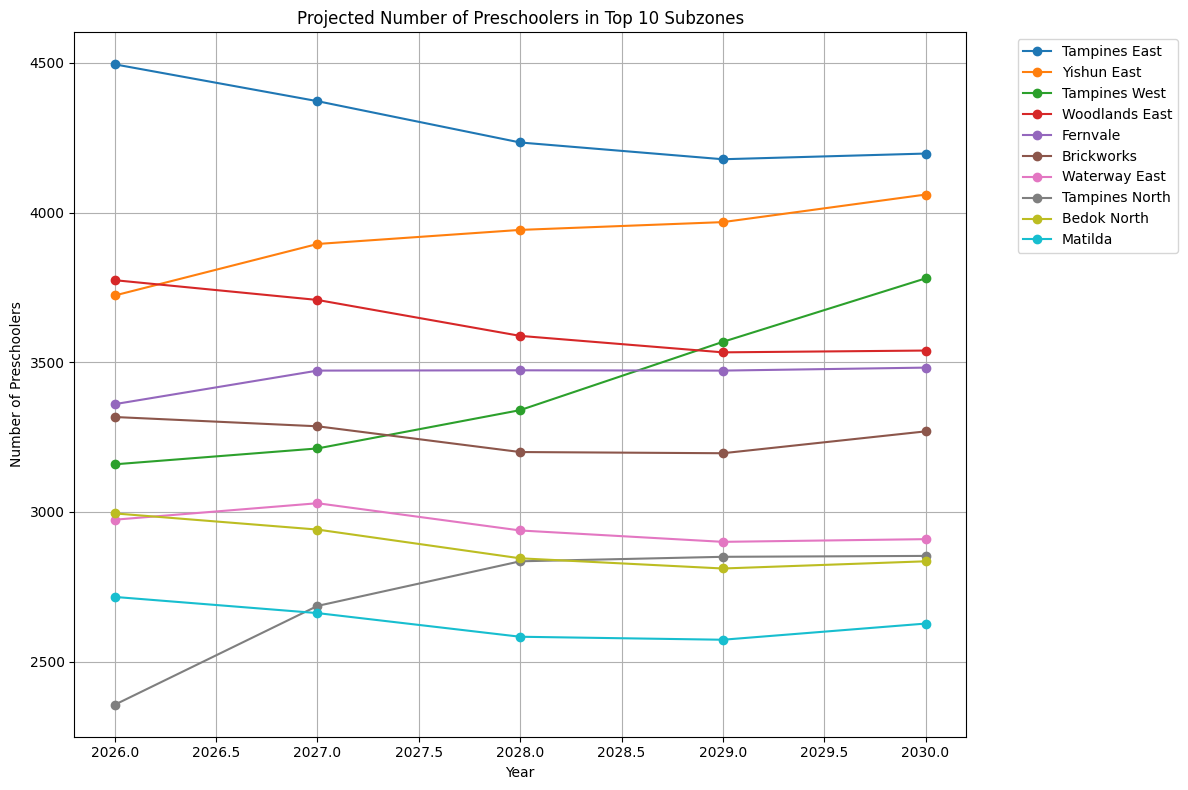

In [23]:
# Get top 10 subzones by total preschoolers at end of forecast period
top_10_subzones = preschoolers_all_forecast.iloc[-1].nlargest(10).index

# Create line plot showing preschooler trends for top 10 subzones
plt.figure(figsize=(12, 8))
for subzone in top_10_subzones:
    plt.plot(preschoolers_all_forecast.index, 
             preschoolers_all_forecast[subzone],
             marker='o',
             label=subzone)

plt.title('Projected Number of Preschoolers in Top 10 Subzones')
plt.xlabel('Year')
plt.ylabel('Number of Preschoolers')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

### 4.2 Forecast Results Interpretation

**Key Findings from the projections:**

- **Total demand remains relatively stable**: ~96,000-99,000 preschoolers annually
- **Geographic concentration**: Top 5 subzones consistently account for ~20% of total demand
- **Emerging demand patterns**: 
  - **Tampines East** leads throughout the forecast period
  - **Yishun East** shows increasing demand over time  
  - **Woodlands East** remains a key demand center
  - **Fernvale** and **Brickworks** represent newer development areas

The consistency in top-demand subzones reflects both existing population density and planned BTO developments in these areas.


# Compute num preschools required in each subzone

## 5. Current Childcare Infrastructure Analysis

### 5.1 Existing Childcare Centre Distribution

We map current childcare centres to subzones using postal code geocoding to understand the baseline supply landscape.


In [24]:
capacity_per_preschool = 100
num_preschools_needed = (preschoolers_all_forecast / capacity_per_preschool).round(0).astype(int)
num_preschools_needed

,Admiralty,Alexandra Hill,Alexandra North,Aljunied,Anak Bukit,Anchorvale,Ang Mo Kio Town Centre,Balestier,Bangkit,Bayshore,...,Yew Tee,Yio Chu Kang East,Yio Chu Kang West,Yishun Central,Yishun East,Yishun South,Yishun West,Yuhua East,Yuhua West,Yunnan
2026,0,0,1,16,0,24,2,11,0,0,...,13,0,8,1,37,0,0,8,0,23
2027,0,0,1,16,0,24,2,11,0,0,...,13,0,8,1,39,0,0,8,0,23
2028,0,0,1,16,0,23,2,11,0,0,...,12,0,8,1,39,0,0,8,0,22
2029,0,0,1,16,0,23,2,11,0,0,...,12,0,8,1,40,0,0,7,0,22
2030,0,0,1,17,0,23,2,11,0,0,...,12,0,8,2,41,0,0,8,0,22


## Get coordinates of existing childcare centres

In [25]:
# Load processed childcare centres data if available, otherwise process it
if PROCESSED_CHILDCARE_CENTRES_DATA_PATH.exists():
    print(f"Loading processed childcare centres data from {PROCESSED_CHILDCARE_CENTRES_DATA_PATH}")
    childcare_centres_data = pd.read_csv(PROCESSED_CHILDCARE_CENTRES_DATA_PATH)
else:
    print(f"Processing childcare centres data from {CHILDCARE_CENTRES_DATA_PATH}")
    childcare_centres_data = pd.read_csv(CHILDCARE_CENTRES_DATA_PATH)

Loading processed childcare centres data from /Users/kchua/case_studies/ecda/data/preschools_data_processed.csv


In [26]:
childcare_centres_data.head()

,tp_code,centre_code,centre_name,organisation_code,organisation_description,service_model,centre_contact_no,centre_email_address,centre_address,postal_code,...,saturday,scheme_type,extended_operating_hours,provision_of_transport,government_subsidy,gst_regisration,last_updated,remarks,latitude,longitude
0,na,PT9885,MMI HOLLAND GROVE PTE LTD,PT,Private Operators,CC,69098000,holland@modern-montessori.com,"24,HOLLAND GROVE ROAD,#01-01,PARKSUITES,278803",278803.0,...,07:00-14:00,na,No,Yes,Yes,No,05/07/2025,na,1.316928,103.783221
1,na,PT4910,MONTESSORI @ GRACELAND PTE LTD,PT,Private Operators,CC,67620117,mmicck@modern-montessori.com,"7,PHOENIX WALK,668111",668111.0,...,na,na,No,No,Yes,Yes,05/07/2025,na,1.376285,103.758282
2,na,PT8548,MODERN MONTESSORI PRESCHOOL CENTRE,PT,Private Operators,CC,65655898,bukitbatok@modern-montessori.com,"368,BUKIT BATOK STREET 31,#01-485,650368",650368.0,...,na,na,No,No,Yes,Yes,05/07/2025,na,1.360381,103.750924
3,na,PT9063,ILHAM CHILD CARE PTE. LTD.,PT,Private Operators,CC,65159723,mas@ilhamchildcare.com,"18,BOON LAY WAY,#01-121,TRADEHUB 21,609966",609966.0,...,na,na,No,Yes,Yes,No,04/07/2025,na,1.328527,103.752855
4,na,PT9329,BRILLIANT TOTS ACADEMY PTE. LTD.,PT,Private Operators,CC,62875535,brillianttots.serangoon@gmail.com,"26,SERANGOON AVENUE 1,556141",556141.0,...,07:00-14:00,na,No,No,Yes,No,04/07/2025,na,1.347364,103.876770


In [27]:
def get_latlon_from_postal(postal_code):
    """
    Query OneMap’s Search API to convert a 6-digit Singapore postal code
    into (latitude, longitude).

    Returns:
        (lat, lon) as floats, or None if no result is found.
    """
    postal_code = str(postal_code)
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={postal_code}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
    headers = {"Authorization": "Bearer **********************"}
    response = requests.get(url, headers=headers).json()
    
    # Get first result
    if int(response["found"]) > 0:
        result = response["results"][0]
        return float(result["LATITUDE"]), float(result["LONGITUDE"])
    else:
        print(f"No result found for postal code {postal_code}")
        return None, None
    
# Example using first postal code in subzones_data
if not PROCESSED_CHILDCARE_CENTRES_DATA_PATH.exists():
    get_latlon_from_postal(int(childcare_centres_data["postal_code"].iloc[0]))

In [28]:
if not PROCESSED_CHILDCARE_CENTRES_DATA_PATH.exists():
    # Save to new columns latitude and longitude
    childcare_centres_data["latitude"], childcare_centres_data["longitude"] = zip(
        *childcare_centres_data.apply(
            lambda x: get_latlon_from_postal(int(x["postal_code"])), axis=1
        )
    )

    childcare_centres_data.to_csv(PROCESSED_CHILDCARE_CENTRES_DATA_PATH, index=False)

    # Calculate percentage of childcare centres with missing coordinates
    missing_coords = childcare_centres_data[
        childcare_centres_data["latitude"].isna() | 
        childcare_centres_data["longitude"].isna()
    ]
    missing_pct = len(missing_coords) / len(childcare_centres_data) * 100
    print(f"{missing_pct:.1f}% of childcare centres have missing coordinates")


## Load and clean up subzone geolocations

In [29]:
subzones_data = gpd.read_file(SUBZONES_DATA_PATH)
subzones_data = subzones_data.set_crs("urn:ogc:def:crs:OGC:1.3:CRS84", allow_override=True)
subzones_data

,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.81454 1.28239 0, 103.81774 1.2..."
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82209 1.28049 0, 103.8221 1.28..."
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84375 1.28508 0, 103.844 1.284..."
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84962 1.28412 0, 103.84955 1.2..."
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.85253 1.28617 0, 103.85253 1.2..."
...,...,...,...
327,kml_328,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84263 1.36323 0, 103.84244 1.3..."
328,kml_329,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.83537 1.37093 0, 103.83576 1.3..."
329,kml_330,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84814 1.36879 0, 103.84834 1.3..."
330,kml_331,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84652 1.34521 0, 103.84649 1.3..."


In [30]:
def extract_subzone_name(description_html):
    """
    Extract subzone name from HTML description and convert to title case.
    
    Args:
        description_html: HTML string containing subzone information
    
    Returns:
        str: Cleaned subzone name in title case
    """
    # Pattern to match the SUBZONE_N row in the HTML table
    # Looks for: <th>SUBZONE_N</th> <td>SUBZONE_NAME</td>
    pattern = r'<th>SUBZONE_N<\/th>\s*<td>([^<]+)<\/td>'
    
    match = re.search(pattern, description_html)
    
    if match:
        # Extract the subzone name
        subzone_name = match.group(1)
        
        # Unescape any HTML entities (though there shouldn't be any in this case)
        subzone_name = html.unescape(subzone_name)
        
        # Convert from ALL CAPS to Title Case
        subzone_name_clean = subzone_name.title()
        
        return subzone_name_clean
    else:
        # Fallback: try to extract any text that looks like a subzone name
        # This handles cases where the HTML structure might be slightly different
        fallback_pattern = r'SUBZONE_N.*?<td>([^<]+)<\/td>'
        fallback_match = re.search(fallback_pattern, description_html, re.IGNORECASE)
        
        if fallback_match:
            return fallback_match.group(1).title()
        else:
            return "Unknown Subzone"


def clean_subzone_names(gdf):
    """
    Add a clean subzone name column to the GeoDataFrame.
    
    Args:
        gdf: GeoDataFrame with 'Description' column containing HTML
        
    Returns:
        GeoDataFrame: Original data with new 'subzone_name_clean' column
    """
    # Create a copy to avoid modifying original data
    gdf_clean = gdf.copy()
    
    # Extract clean subzone names
    gdf_clean['subzone_name_clean'] = gdf_clean['Description'].apply(extract_subzone_name)
    
    return gdf_clean

In [31]:
# Clean the subzone names
subzones_data = clean_subzone_names(subzones_data)
subzones_data.head()

,Name,Description,geometry,subzone_name_clean
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.81454 1.28239 0, 103.81774 1.2...",Depot Road
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82209 1.28049 0, 103.8221 1.28...",Bukit Merah
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84375 1.28508 0, 103.844 1.284...",Chinatown
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84962 1.28412 0, 103.84955 1.2...",Phillip
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.85253 1.28617 0, 103.85253 1.2...",Raffles Place


## Compute number of existing childcare centres in each subzone

In [32]:
def count_childcare_centres_per_subzone(subzones_data, childcare_centres_data):
    """
    Count number of childcare centres that fall within each subzone.
    
    Args:
        subzones_data: GeoDataFrame containing subzone polygons
        childcare_centres_data: DataFrame containing childcare centre locations
        
    Returns:
        GeoDataFrame: subzones_data with new 'num_childcare_centres' column
    """
    # Create copy to avoid modifying original
    subzones = subzones_data.copy()
    
    # Initialize column to count childcare centres per subzone
    subzones["num_childcare_centres"] = 0

    # Process each childcare centre
    for _, centre in childcare_centres_data.iterrows():
        # Skip if no lat/lon available
        if pd.isna(centre.latitude) or pd.isna(centre.longitude):
            continue
            
        # Create point geometry from lat/lon
        point = Point(centre.longitude, centre.latitude)
        
        # Find which subzone contains this point
        for idx, subzone in subzones.iterrows():
            if point.within(subzone.geometry):
                subzones.loc[idx, "num_childcare_centres"] += 1
                break
                
    return subzones

subzones_data = count_childcare_centres_per_subzone(subzones_data, childcare_centres_data)
subzones_data.head()

,Name,Description,geometry,subzone_name_clean,num_childcare_centres
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.81454 1.28239 0, 103.81774 1.2...",Depot Road,4
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82209 1.28049 0, 103.8221 1.28...",Bukit Merah,2
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84375 1.28508 0, 103.844 1.284...",Chinatown,0
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84962 1.28412 0, 103.84955 1.2...",Phillip,0
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.85253 1.28617 0, 103.85253 1.2...",Raffles Place,0


In [33]:
subzones_data

,Name,Description,geometry,subzone_name_clean,num_childcare_centres
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.81454 1.28239 0, 103.81774 1.2...",Depot Road,4
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82209 1.28049 0, 103.8221 1.28...",Bukit Merah,2
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84375 1.28508 0, 103.844 1.284...",Chinatown,0
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84962 1.28412 0, 103.84955 1.2...",Phillip,0
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.85253 1.28617 0, 103.85253 1.2...",Raffles Place,0
...,...,...,...,...,...
327,kml_328,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84263 1.36323 0, 103.84244 1.3...",Upper Thomson,16
328,kml_329,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.83537 1.37093 0, 103.83576 1.3...",Shangri-La,8
329,kml_330,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84814 1.36879 0, 103.84834 1.3...",Townsville,8
330,kml_331,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84652 1.34521 0, 103.84649 1.3...",Marymount,12


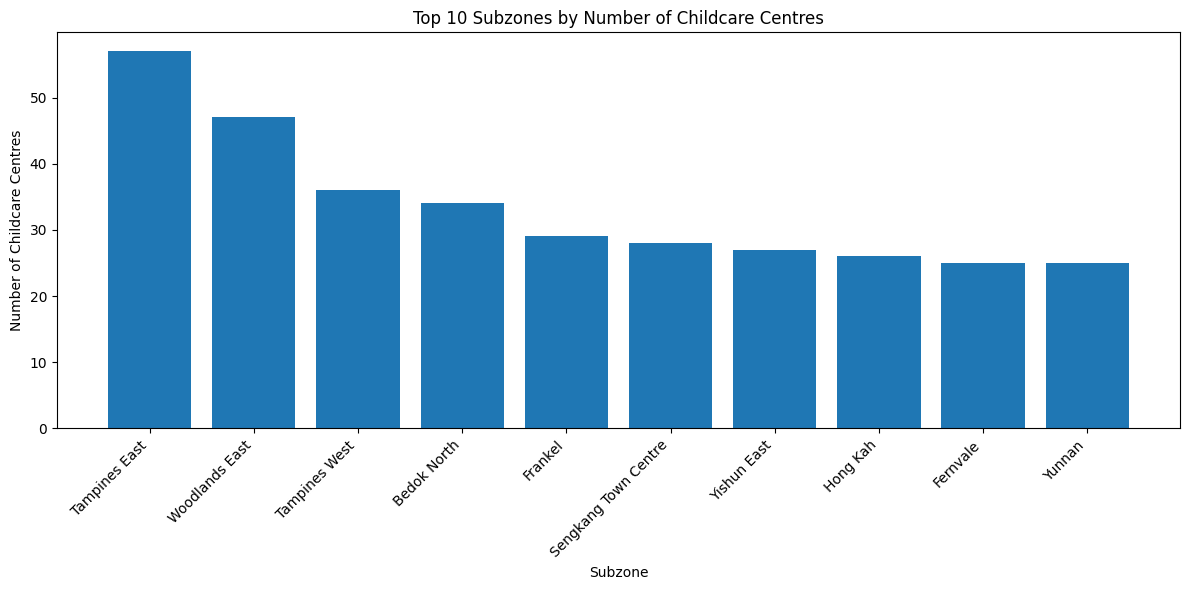

In [34]:
# Get top 10 subzones by number of childcare centres
top_10_subzones = subzones_data.nlargest(10, 'num_childcare_centres')

# Create bar plot
plt.figure(figsize=(12,6))
plt.bar(top_10_subzones['subzone_name_clean'], top_10_subzones['num_childcare_centres'])

# Customize plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('Subzone')
plt.ylabel('Number of Childcare Centres')
plt.title('Top 10 Subzones by Number of Childcare Centres')

# Adjust layout to prevent label cutoff
plt.tight_layout()

## 6. Supply-Demand Gap Analysis

### 6.1 Preschool Capacity Requirements

Using the ECDA planning norm of 100 children per childcare centre, we convert projected preschooler counts into required number of centres for each subzone.


In [35]:
num_preschools_needed

,Admiralty,Alexandra Hill,Alexandra North,Aljunied,Anak Bukit,Anchorvale,Ang Mo Kio Town Centre,Balestier,Bangkit,Bayshore,...,Yew Tee,Yio Chu Kang East,Yio Chu Kang West,Yishun Central,Yishun East,Yishun South,Yishun West,Yuhua East,Yuhua West,Yunnan
2026,0,0,1,16,0,24,2,11,0,0,...,13,0,8,1,37,0,0,8,0,23
2027,0,0,1,16,0,24,2,11,0,0,...,13,0,8,1,39,0,0,8,0,23
2028,0,0,1,16,0,23,2,11,0,0,...,12,0,8,1,39,0,0,8,0,22
2029,0,0,1,16,0,23,2,11,0,0,...,12,0,8,1,40,0,0,7,0,22
2030,0,0,1,17,0,23,2,11,0,0,...,12,0,8,2,41,0,0,8,0,22


In [36]:
subzones_data

,Name,Description,geometry,subzone_name_clean,num_childcare_centres
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.81454 1.28239 0, 103.81774 1.2...",Depot Road,4
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82209 1.28049 0, 103.8221 1.28...",Bukit Merah,2
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84375 1.28508 0, 103.844 1.284...",Chinatown,0
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84962 1.28412 0, 103.84955 1.2...",Phillip,0
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.85253 1.28617 0, 103.85253 1.2...",Raffles Place,0
...,...,...,...,...,...
327,kml_328,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84263 1.36323 0, 103.84244 1.3...",Upper Thomson,16
328,kml_329,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.83537 1.37093 0, 103.83576 1.3...",Shangri-La,8
329,kml_330,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84814 1.36879 0, 103.84834 1.3...",Townsville,8
330,kml_331,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84652 1.34521 0, 103.84649 1.3...",Marymount,12


In [37]:
# Get existing number of childcare centres for each subzone
existing_preschools = subzones_data[subzones_data["subzone_name_clean"].isin(num_preschools_needed.columns)].copy()
existing_preschools = existing_preschools.set_index("subzone_name_clean")[["num_childcare_centres", "geometry"]]
existing_preschools

,num_childcare_centres,geometry
subzone_name_clean,,
Depot Road,4,"POLYGON Z ((103.81454 1.28239 0, 103.81774 1.2..."
Bukit Merah,2,"POLYGON Z ((103.82209 1.28049 0, 103.8221 1.28..."
Chinatown,0,"POLYGON Z ((103.84375 1.28508 0, 103.844 1.284..."
China Square,0,"POLYGON Z ((103.84859 1.28232 0, 103.84852 1.2..."
Tiong Bahru,5,"POLYGON Z ((103.83105 1.28716 0, 103.83176 1.2..."
...,...,...
Nee Soon,0,"POLYGON Z ((103.81111 1.41527 0, 103.81466 1.4..."
Upper Thomson,16,"POLYGON Z ((103.84263 1.36323 0, 103.84244 1.3..."
Shangri-La,8,"POLYGON Z ((103.83537 1.37093 0, 103.83576 1.3..."


In [38]:
# Show subzones with the most preschools
existing_preschools.sort_values(by="num_childcare_centres", ascending=False).head()

,num_childcare_centres,geometry
subzone_name_clean,,
Tampines East,57,"POLYGON Z ((103.96089 1.3606 0, 103.96115 1.36..."
Woodlands East,47,"POLYGON Z ((103.80444 1.43337 0, 103.80351 1.4..."
Tampines West,36,"POLYGON Z ((103.94683 1.34146 0, 103.94682 1.3..."
Bedok North,34,"POLYGON Z ((103.9437 1.33537 0, 103.94844 1.33..."
Frankel,29,"POLYGON Z ((103.91016 1.30561 0, 103.90998 1.3..."


In [39]:
# For each year and subzone, calculate the gap between needed and existing centres
# Negative values indicate shortage, positive values indicate surplus
preschool_gap = num_preschools_needed.copy()

# Ensure we only compare subzones that exist in both datasets
common_subzones = list(set(existing_preschools.index) & set(preschool_gap.columns))

for year in preschool_gap.index:
    for subzone in common_subzones:
        preschool_gap.loc[year, subzone] = (
            existing_preschools.loc[subzone, "num_childcare_centres"]
            - preschool_gap.loc[year, subzone]
        )

preschool_gap

,Admiralty,Alexandra Hill,Alexandra North,Aljunied,Anak Bukit,Anchorvale,Ang Mo Kio Town Centre,Balestier,Bangkit,Bayshore,...,Yew Tee,Yio Chu Kang East,Yio Chu Kang West,Yishun Central,Yishun East,Yishun South,Yishun West,Yuhua East,Yuhua West,Yunnan
2026,10,10,2,9,17,-4,2,7,6,3,...,-2,6,-2,4,-10,17,18,2,2,2
2027,10,10,2,9,17,-4,2,7,6,3,...,-2,6,-2,4,-12,17,18,2,2,2
2028,10,10,2,9,17,-3,2,7,6,3,...,-1,6,-2,4,-12,17,18,2,2,3
2029,10,10,2,9,17,-3,2,7,6,3,...,-1,6,-2,4,-13,17,18,3,2,3
2030,10,10,2,8,17,-3,2,7,6,3,...,-1,6,-2,3,-14,17,18,2,2,3


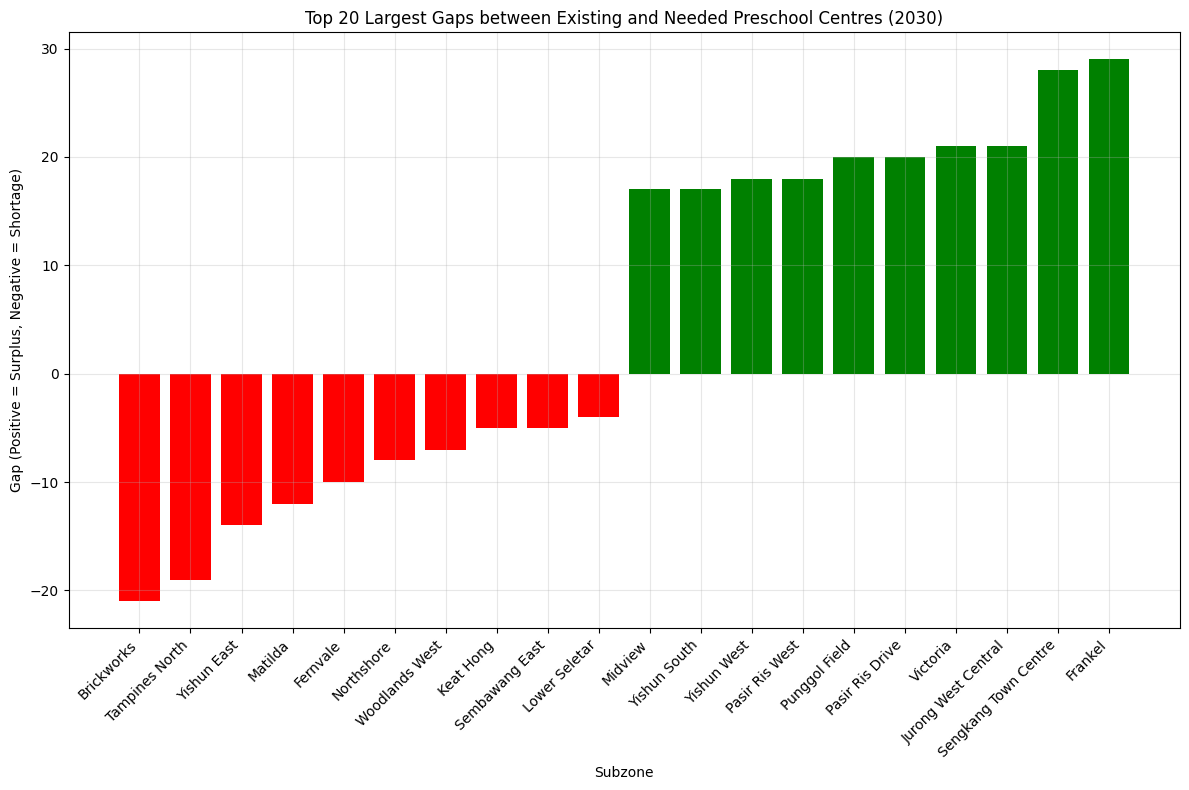

In [43]:
# Widget doesn't show well in PDF/on Github
# @interact(year=IntSlider(min=min(forecast_years), max=max(forecast_years), value=2030, description='Year:'))

def plot_gap(year):
    # Get top 20 largest gaps (both positive and negative)
    gaps = preschool_gap.loc[year].sort_values()
    top_10_shortages = gaps.head(10)
    top_10_surpluses = gaps.tail(10)
    top_10_gaps = pd.concat([top_10_shortages, top_10_surpluses])
    
    plt.figure(figsize=(12, 8))
    colors = ['red' if x < 0 else 'green' for x in top_10_gaps]
    plt.bar(top_10_gaps.index, top_10_gaps, color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top 20 Largest Gaps between Existing and Needed Preschool Centres ({year})')
    plt.xlabel('Subzone')
    plt.ylabel('Gap (Positive = Surplus, Negative = Shortage)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_gap(2030)

### 6.2 Priority Areas for Infrastructure Development

**Critical shortages identified for 2030:**

1. **Brickworks** (-21 centres)
2. **Tampines North** (-19 centres)
3. **Yishun East** (-14 centres)
4. **Matilda** (-12 centres)
5. **Fernvale** (-10 centres)

**Recommendation**: These 5 subzones should be prioritized for new childcare centre development or expansion of existing facilities.


In [44]:
# Get top 5 subzones with largest preschool shortages in 2030
shortage_by_subzone = preschool_gap.loc[2030].sort_values()
print("Top 5 subzones with largest preschool shortages in 2030:")
print(shortage_by_subzone.head())


Top 5 subzones with largest preschool shortages in 2030:
Brickworks       -21
Tampines North   -19
Yishun East      -14
Matilda          -12
Fernvale         -10
Name: 2030, dtype: int64


## 7. Model Validation and Quality Checks

### 7.1 Cross-Validation Against National Birth Statistics

We validate our preschooler forecasts against official live birth data to ensure our estimates are within reasonable bounds.


### Number of live-births
This should match roughly match the number of preschoolers each year.

In [45]:
# A cohort of preschoolers spans about 5.5 years (18–72 months old)
annual_live_births = fertility_data.loc["Total Live-Births"][["2019", "2020", "2021", "2022", "2023", "2024"]]
# We halve 2024, and sum the rest
annual_live_births.loc["2024"] = annual_live_births.loc["2024"] / 2
preschoolers_2024 = annual_live_births.sum()
print(f"Preschoolers in 2024: {preschoolers_2024}")

Preschoolers in 2024: 202538.5


In [46]:
annual_preschoolers_forecast = preschoolers_all_forecast.sum(axis=1)
annual_preschoolers_forecast

2026    96441.0
2027    96629.0
2028    95877.0
2029    96530.0
2030    99044.0
dtype: float64

Our forecasts are likely underestimating the number of preschoolers as we did not account for those in resale and private properties.

### 7.2 Model Limitations and Expected Underestimation

**Validation Results:**
- Our forecasts (~96k-99k preschoolers) vs. historical births (~203k total for 2024 preschool cohort)
- The gap is expected and explained by our modeling scope:

**Sources of underestimation:**
1. **Resale flat residents**: We only model BTO residents for new demand
2. **Private property residents**: Not included in our analysis  
3. **Cross-subzone enrollment**: Some parents may send children to centres outside their residential subzone
4. **Immigration and mobility**: Population changes not captured in our static 2020 baseline

**Implication**: Our forecasts provide conservative estimates of minimum required capacity, with actual demand likely higher.


## 8. Interactive Decision Support Tool

### 8.1 Geospatial Visualization and Analysis

The interactive maps below provide a comprehensive view of the preschool demand landscape, showing:

1. **Current Supply**: Existing childcare centre distribution
2. **Projected Demand**: Forecasted preschooler populations by subzone
3. **Capacity Requirements**: Number of centres needed to meet demand
4. **Priority Zones**: Areas with critical shortages (highlighted in red)

**Usage Instructions:**
- Use the year slider to explore different forecast periods
- Red areas indicate priority zones requiring immediate attention
- Compare current supply vs. projected demand to identify mismatches


In [47]:
def prepare_mapping_data_merge(year=2030):
    """Alternative approach using explicit merge operations."""
    
    # Start with subzone geographic data
    map_data = subzones_data.copy()
    
    # Prepare forecast data as DataFrames for merging
    forecast_data = pd.DataFrame({
        'subzone_name_clean': preschoolers_all_forecast.columns,
        'projected_preschoolers': preschoolers_all_forecast.loc[year].values,
        'preschools_needed': num_preschools_needed.loc[year].values,
        'preschool_gap': preschool_gap.loc[year].values
    })
    
    # Merge with geographic data
    map_data = map_data.merge(forecast_data, 
                             on='subzone_name_clean', 
                             how='left')
    
    # Fill missing values with 0
    forecast_cols = ['projected_preschoolers', 'preschools_needed', 'preschool_gap']
    map_data[forecast_cols] = map_data[forecast_cols].fillna(0)
    
    # Calculate derived columns
    map_data['shortage'] = -map_data['preschool_gap'].clip(upper=0)
    map_data['surplus'] = map_data['preschool_gap'].clip(lower=0)
    
    # Set index for mapping
    map_data = map_data.set_index('subzone_name_clean')
    
    return map_data

In [48]:
def plot_preschool_analysis(map_data, year=2030):
    """
    Create a multi-panel visualization showing preschool demand analysis by subzone.
    
    Args:
        map_data: GeoDataFrame containing subzone geometries and analysis data
        year: Year to display in titles (default 2030)
    """
    # Multi-panel demand/supply analysis map
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle(f'Preschool Demand Analysis by Subzone ({year})', fontsize=16, fontweight='bold')

    # 1. Current Supply
    ax1 = axes[0,0]
    map_data.plot(column='num_childcare_centres', 
                       ax=ax1, 
                       legend=True,
                       cmap='Blues',
                       edgecolor='white',
                       linewidth=0.5)
    ax1.set_title('Current Childcare Centres', fontweight='bold')
    ax1.axis('off')

    # 2. Projected Demand  
    ax2 = axes[0,1]
    map_data.plot(column='projected_preschoolers',
                       ax=ax2,
                       legend=True, 
                       cmap='Oranges',
                       edgecolor='white',
                       linewidth=0.5)
    ax2.set_title(f'Projected Preschoolers ({year})', fontweight='bold')
    ax2.axis('off')

    # 3. Preschools Needed
    ax3 = axes[1,0] 
    map_data.plot(column='preschools_needed',
                       ax=ax3,
                       legend=True,
                       cmap='Reds', 
                       edgecolor='white',
                       linewidth=0.5)
    ax3.set_title(f'Preschools Needed ({year})', fontweight='bold')
    ax3.axis('off')

    # 4. Shortage Areas (Priority Zones)
    ax4 = axes[1,1]
    shortage_data = map_data[map_data['shortage'] > 0]
    map_data.plot(color='lightgray', ax=ax4, edgecolor='white', linewidth=0.5)
    shortage_data.plot(column='shortage',
                       ax=ax4,
                       legend=True,
                       cmap='Reds',
                       edgecolor='darkred',
                       linewidth=1)
    ax4.set_title('Preschool Shortages (Red = Priority Areas)', fontweight='bold')
    ax4.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

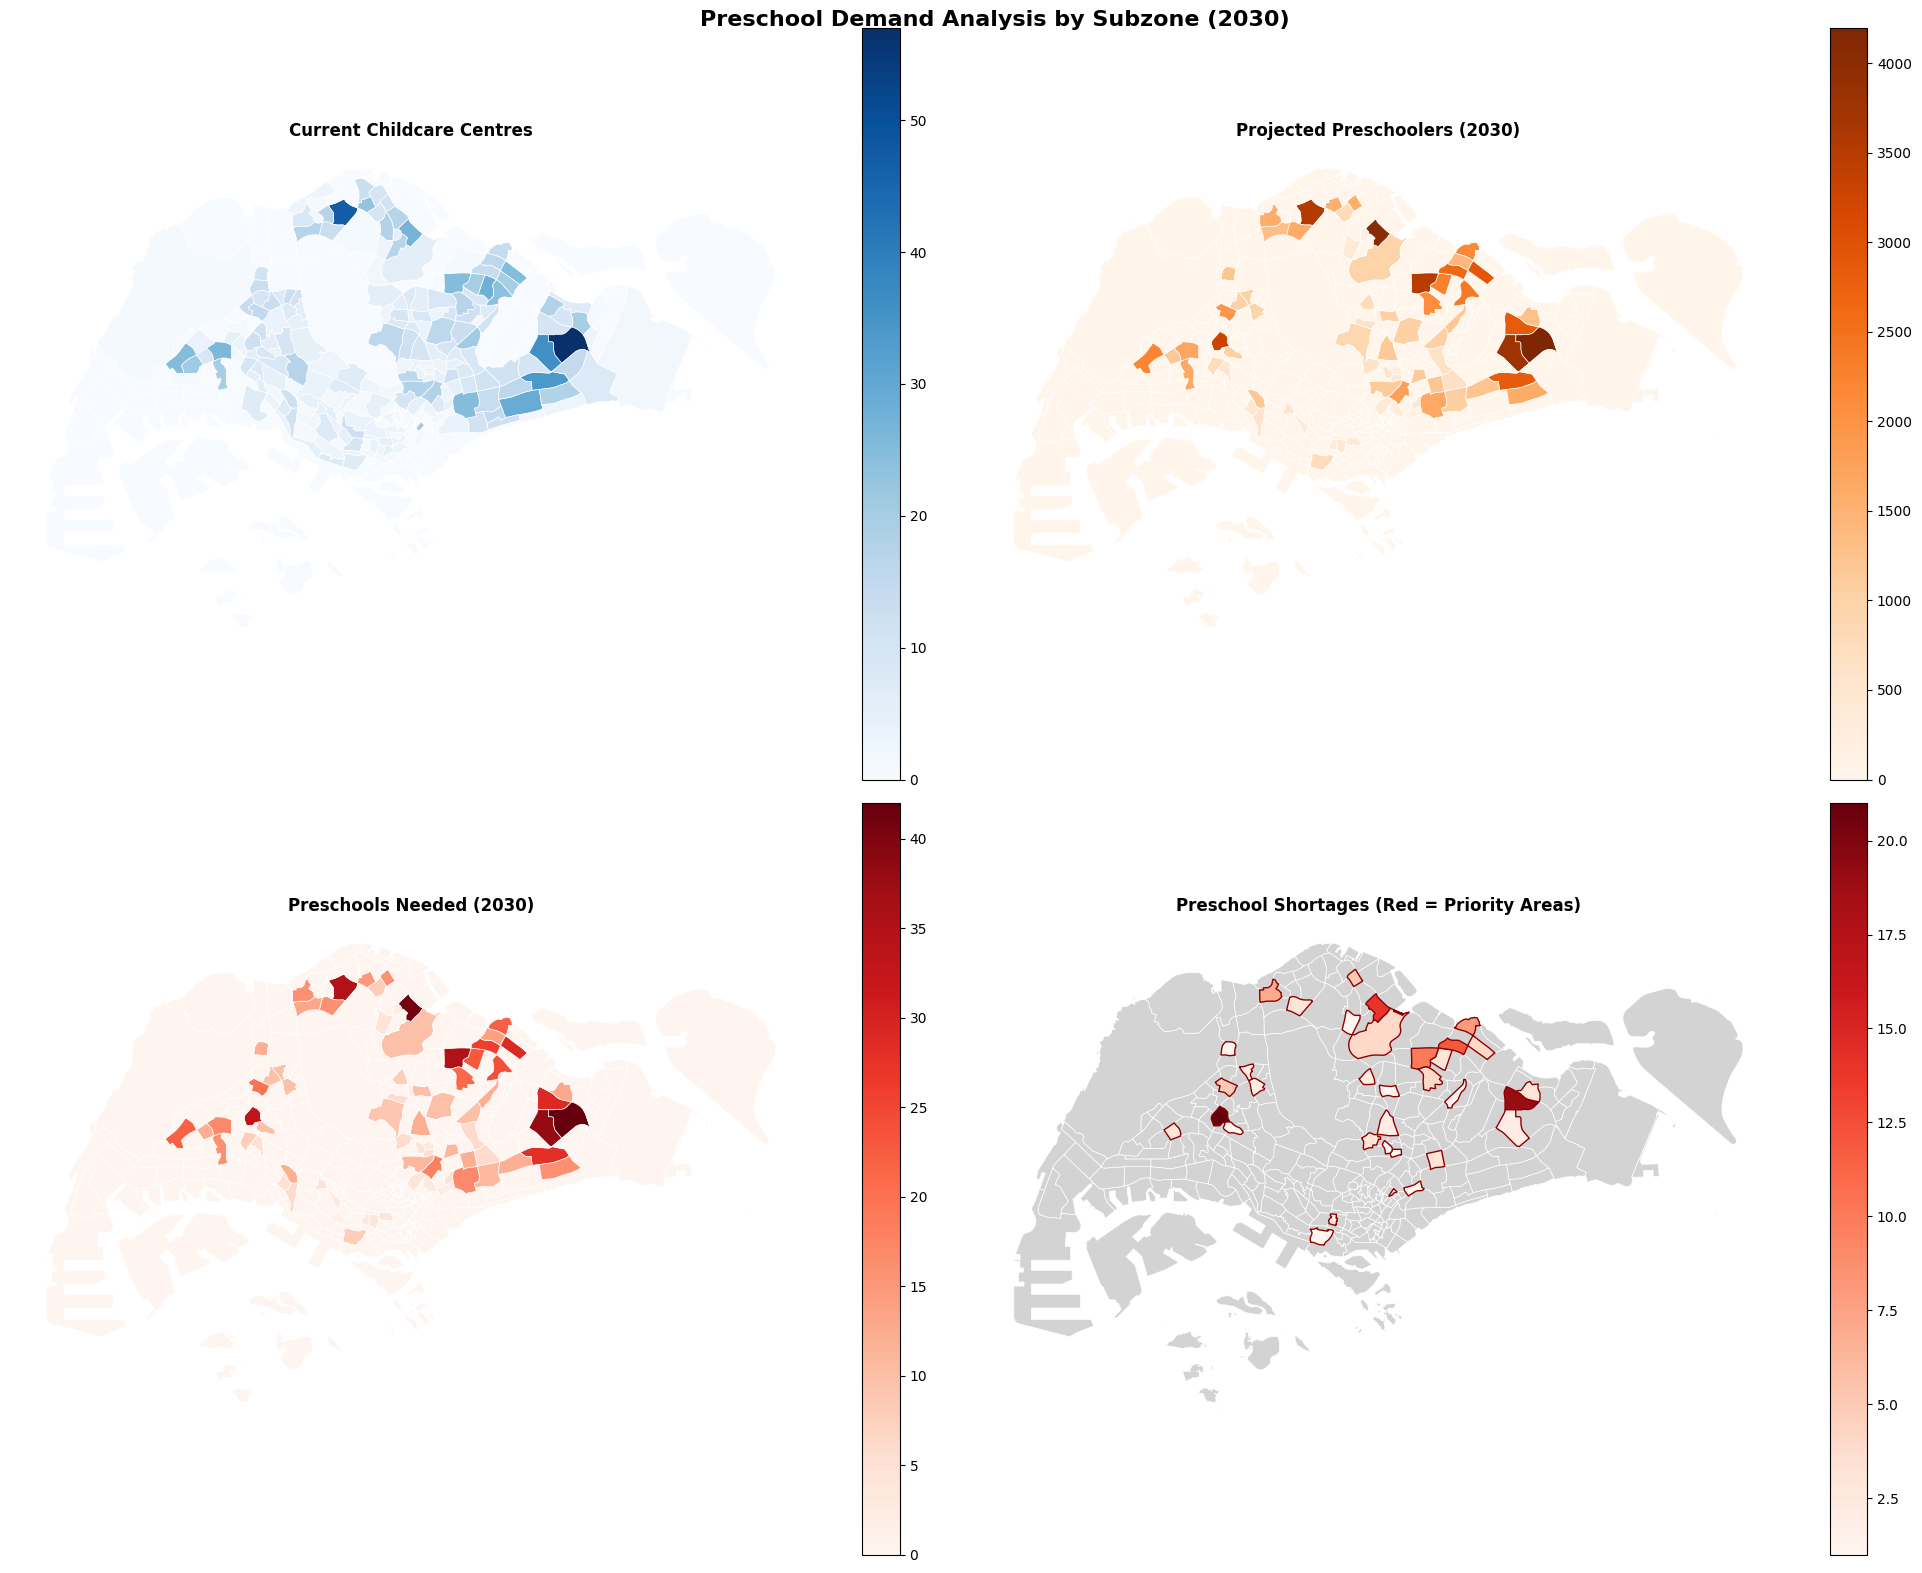

In [ ]:
# Widget doesn't show well in PDF/on Github
# Create interactive widget to scroll through years
# @interact(year=IntSlider(min=min(forecast_years), max=max(forecast_years), step=1, value=2030, description='Year:'))

def update_plot(year):
    map_data = prepare_mapping_data_merge(year)
    plot_preschool_analysis(map_data, year)

update_plot(2030)

## 9. Executive Summary and Recommendations

### Key Findings
- **Geographic Concentration**: Demand is concentrated in specific subzones, with top 5 areas accounting for ~20% of total demand

- **Critical Shortage Areas**: Five subzones require immediate attention:
   - **Brickworks** (-21 centres needed)
   - **Tampines North** (-19 centres needed)  
   - **Yishun East** (-14 centres needed)
   - **Matilda** (-12 centres needed)
   - **Fernvale** (-10 centres needed)

### Strategic Recommendations

- Prioritize new centre development in the 5 critical shortage areas
- Establish regular monitoring system using updated population and BTO data
- Consider incentives for private providers to establish centres in shortage areas
- Refine model with actual enrollment data as it becomes available

### Model Evolution for Ongoing Use
This analysis provides a foundation for ECDA's ongoing planning. The methodology can be enhanced by:
- Incorporating resale flat and private property residents
- Adding migration and population mobility patterns
